In [3]:
import numpy as np
import argparse

import dlib
import glob
import os
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import imgaug.augmenters as iaa
import scipy.io
import tensorflow as tf

In [5]:
mat = scipy.io.loadmat("/home/framaz/eye_control/MPIIGaze/Data/Normalized/p01/day04.mat")
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu May 31 18:56:34 2018',
 '__version__': '1.0',
 '__globals__': [],
 'data': array([[(array([[(array([[-0.2212677 ,  0.23192673, -0.94723312],
        [-0.04079625,  0.06116763, -0.99729343],
        [ 0.02730508,  0.18939407, -0.98152143],
        ...,
        [-0.07158868,  0.1438829 , -0.98700191],
        [ 0.08484398,  0.27323227, -0.95819916],
        [-0.2335198 ,  0.27084495, -0.93386911]]), array([[[255, 255, 254, ...,  68, 129, 157],
         [255, 254, 251, ...,  22,  29,  42],
         [255, 251, 251, ...,   4,   2,   4],
         ...,
         [249, 245, 245, ...,  33,  57,  45],
         [249, 248, 245, ...,  35,  86,  37],
         [248, 248, 249, ...,  46,  80,  21]],
 
        [[255, 255, 254, ...,   3,   5,   5],
         [255, 255, 251, ...,   7,   4,   3],
         [255, 254, 252, ...,  58,  32,  16],
         ...,
         [245, 242, 238, ..., 180, 186,  56],
         [245, 244, 236, ..., 186, 1

mat['data'][0][0][0][0][0][0] some 3d vector <br>
mat['data'][0][0][0][0][0][1] eyes maybe <br>
mat['data'][0][0][0][0][0][2] some 3d vector


mat['data'][0][0][eye_num] eye num

(3,)
0.05148824810462738


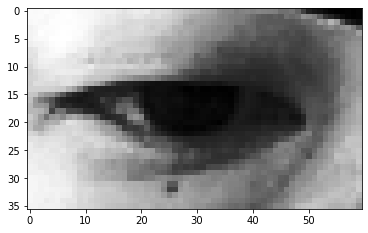

In [9]:
import math
print(mat['data'][0][0][0][0][0][0][0].shape)
pics = mat['data'][0][0][0][0][0][1]
coords_1 = mat['data'][0][0][0][0][0][0]
coords_2 = mat['data'][0][0][0][0][0][2]
plt.imshow(pics[3], cmap='gray')
print(math.asin(coords_2[2][1]))

pics = pics.reshape(-1, 36, 60, 1)
pics = pics.astype(dtype=np.float32)
pics /= 255.0
coords_1 = coords_1.astype(dtype=np.float32)

In [19]:
import math
def get_pixel(x, y, z, a, b, c, d, 
              width=0.54, heigth=0.30375, 
              pixel_width=1920, pixel_heigth=1080):
    """k = -d / (a * x + b * y + c * z)
    print(x[0].item())
    x = k * x
    y = k * y
    z = k * z
    pixel_x = x / width * pixel_width
    pixel_y = y / heigth * pixel_heigth
    return pixel_x, pixel_y """
    fl = np.array([a, b, c])
    ratios = np.array([width * pixel_width, heigth * pixel_heigth])
    bottom = a*x+b*y+c*z
    k = d / bottom
    return x * k * ratios[0], y * k * ratios[1]
@tf.function
def generic_pixel_loss(y_true, y_pred, pixel_func, sample_weight=0):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    pix_pred = pixel_func(y_pred)
    pix_true = pixel_func(y_true)
    return tf.reduce_mean(tf.sqrt(tf.square(pix_pred - pix_true)))

from functools import partial
pixel_get = partial(get_pixel, a=0, b=0, c=1, d=-1)
for i in coords_1:
    print(pixel_get(i[0], i[1], i[2]))

(-242.18995489221422, 80.32190128200247)
(-42.412344823245945, 20.120500561072095)
(28.842881833502087, 63.300426737015414)
(-12.144260036267001, 86.70826421083764)
(-143.28871544119085, 81.19919085278647)
(-116.91778389854846, 93.85282992624082)
(-60.73562253689483, 24.60970682877639)
(186.62757361080088, 75.95715500531333)
(202.92407063135383, 50.335689525993935)
(-250.2403166471612, 26.095473496682423)
(-26.688641890582883, 82.58430478374136)
(-153.6589181177282, 72.16898959072554)
(-11.843024448264439, 30.534976345156817)
(-221.58356543629378, 108.22268940103035)
(-81.5801825300925, 51.41084408049812)
(-261.6535441827065, 55.39829666502818)
(163.44681193506196, 86.49914862596617)
(202.78441003847237, 44.56794343846905)
(-135.23095531473007, 36.409669372325)
(13.693551074209573, 93.14465540685784)
(-228.14156170661425, 107.8155186685967)
(86.32325528281046, 12.062651308250608)
(18.708107468915248, 46.46225819196035)
(98.66921523160259, 89.55357160185568)
(-172.33365410007806, 11.438

In [213]:
import math
def get_pixel(tens, a, b, c, d, 
              width=0.54, heigth=0.30375, 
              pixel_width=1920, pixel_heigth=1080):
    """k = -d / (a * x + b * y + c * z)
    print(x[0].item())
    x = k * x
    y = k * y
    z = k * z
    pixel_x = x / width * pixel_width
    pixel_y = y / heigth * pixel_heigth
    return pixel_x, pixel_y """
    fl = np.array([a, b, c])
    ratios = np.array([width * pixel_width, heigth * pixel_heigth])
    k = d / tf.math.reduce_sum(tens * fl, 1)
    k = tf.convert_to_tensor([k, k, k])
    k = tf.transpose(k)
    tens = tens * k
    tens = tens[:, 0:2]
    tens = tens * ratios
    return tens
def generic_pixel_loss(y_pred, y_true, pixel_func, sample_weight=0):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

    pix_pred = pixel_func(y_pred)
    pix_true = pixel_func(y_true)
    return tf.reduce_mean(tf.sqrt(tf.square(pix_pred - pix_true)))

from functools import partial
pixel_loss = partial(generic_pixel_loss, pixel_func=
                    partial(get_pixel,
                           a=0, b=0, c=1, d=-1))




In [275]:
class My_shape_logging_layer(tf.keras.layers.Layer):
    def __init__(self):
        super(My_shape_logging_layer, self).__init__()
    def build(self, input_shape):
        print(input_shape)
    def call(self, input):
        return input
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(60, 3, input_shape=(36, 60, 1), activation="relu"),
    tf.keras.layers.MaxPooling2D(3),
    My_shape_logging_layer(),
    tf.keras.layers.Conv2D(60, 3, activation="tanh"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(30, 3),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1500, activation="softplus"),
    tf.keras.layers.Dense(3)
])
model.compile(
    optimizer='adam',
    loss=pixel_loss)
model.fit(pics[10:], coords_1[10:], batch_size=32, epochs=200, validation_split=0.2)

"""with tf.GradientTape() as tape:
    values = model(pics[:32], training=True)
    loss_value = pixel_loss(values, coords_1[0:32])
    print(loss_value)"""

(None, 11, 19, 60)
Train on 526 samples, validate on 132 samples
Epoch 1/200
526/526 [==============================] - 1s 1ms/sample - loss: 202.8845 - val_loss: 76.7750
Epoch 2/200
526/526 [==============================] - 0s 281us/sample - loss: 76.8782 - val_loss: 68.0554
Epoch 3/200
526/526 [==============================] - 0s 281us/sample - loss: 72.4795 - val_loss: 68.4494
Epoch 4/200
526/526 [==============================] - 0s 295us/sample - loss: 70.3293 - val_loss: 63.1927
Epoch 5/200
526/526 [==============================] - 0s 281us/sample - loss: 62.4620 - val_loss: 55.6032
Epoch 6/200
526/526 [==============================] - 0s 285us/sample - loss: 52.0019 - val_loss: 47.3274
Epoch 7/200
526/526 [==============================] - 0s 278us/sample - loss: 39.8589 - val_loss: 44.9306
Epoch 8/200
526/526 [==============================] - 0s 277us/sample - loss: 35.7878 - val_loss: 39.1720
Epoch 9/200
526/526 [==============================] - 0s 280us/sample - loss: 3

526/526 [==============================] - 0s 277us/sample - loss: 4.3790 - val_loss: 17.2517
Epoch 153/200
526/526 [==============================] - 0s 272us/sample - loss: 7.7243 - val_loss: 16.5437
Epoch 154/200
526/526 [==============================] - 0s 259us/sample - loss: 7.2526 - val_loss: 16.7956
Epoch 155/200
526/526 [==============================] - 0s 272us/sample - loss: 4.4286 - val_loss: 17.0890
Epoch 156/200
526/526 [==============================] - 0s 264us/sample - loss: 5.0899 - val_loss: 17.3006
Epoch 157/200
526/526 [==============================] - 0s 272us/sample - loss: 4.1865 - val_loss: 17.8988
Epoch 158/200
526/526 [==============================] - 0s 282us/sample - loss: 3.9624 - val_loss: 17.7489
Epoch 159/200
526/526 [==============================] - 0s 284us/sample - loss: 3.7969 - val_loss: 17.3040
Epoch 160/200
526/526 [==============================] - 0s 278us/sample - loss: 4.3467 - val_loss: 16.5003
Epoch 161/200
526/526 [===================

'with tf.GradientTape() as tape:\n    values = model(pics[:32], training=True)\n    loss_value = pixel_loss(values, coords_1[0:32])\n    print(loss_value)'

float32
[[-0.2212677   0.23192674 -0.94723314]
 [-0.04079625  0.06116764 -0.9972934 ]
 [ 0.02730508  0.18939407 -0.9815214 ]
 [-0.0113236   0.25552225 -0.96673685]
 [-0.1329632   0.23813657 -0.9620872 ]
 [-0.10778657  0.27345532 -0.95582646]
 [-0.05831632  0.07468064 -0.99550086]
 [ 0.17272826  0.2221832  -0.95958304]
 [ 0.18993583  0.1489033  -0.9704392 ]
 [-0.23392294  0.07709668 -0.9691936 ]]


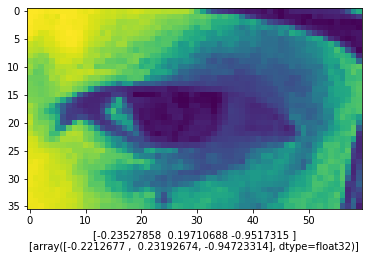

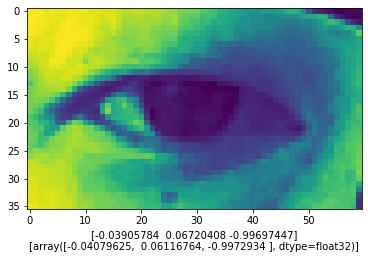

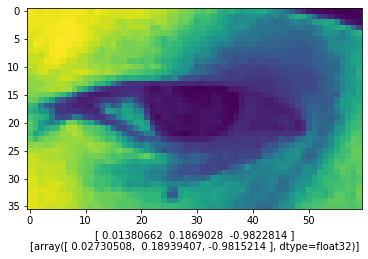

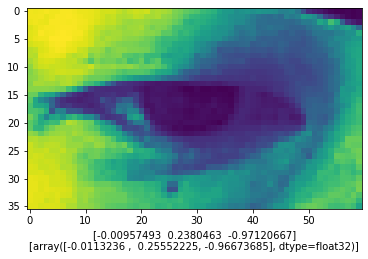

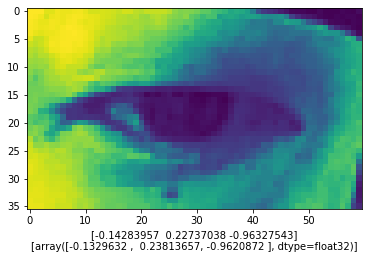

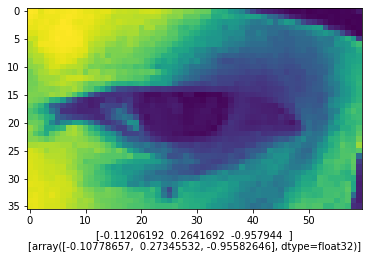

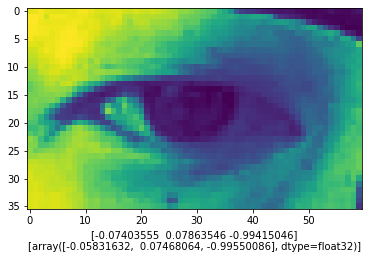

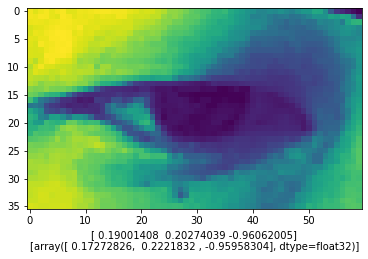

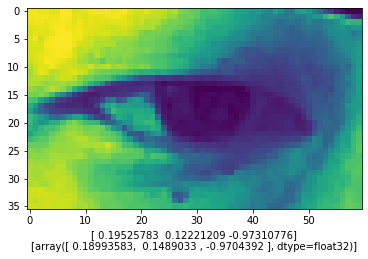

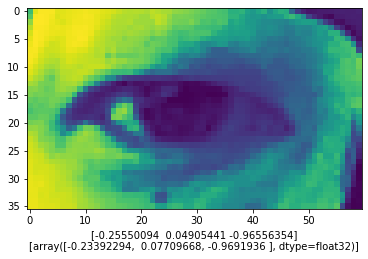

In [279]:
print(pics.dtype)
predictions = model.predict(pics[:10])
print(coords_1[:10])
for i in range(10):
    plt.xlabel(F'{predictions[i] / np.linalg.norm(predictions[i])}\n{[coords_1[i]]}')
    plt.imshow(pics[i].reshape(36, 60))
    plt.show()